# Online Status Count Analysis

## Preparation

The following two scripts are activated to:
1. Set up the MongoDB connection and
2. Read the pre-generated ID-table to fetch names of roles and channels.

In [1]:
%run -i scripts/setup-mongo.py
%run -i scripts/read-idtable.py

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date, time
from math import floor

In [3]:
# Get messages collection
coll_status = mongo_db['status']

## Data Structure

A `status` object in the database looks like following:

```json
{
  "_id": "5cc6188449bed4b3995d1318",
  "guildid": "307084334198816769",
  "timestamp": "2019-04-28T21:17:56.809Z",
  "online": 49,
  "offline": 664,
  "dnd": 28,
  "away": 20
}
```

And a `statusrole` object looks like following *(simplified)*:

```json
{
  "_id": "5cc6188449bed4b3995d1317",
  "guildid": "307084334198816769",
  "timestamp": "2019-04-28T21:17:56.809Z",
  "roles": [
    {
      "roleid": "533817176637964308",
      "online": 2,
      "offline": 5,
      "dnd": 0,
      "away": 0
    },
    // ...
  ]
}
```

## Total User Count over Time

First we will analyze the evolution of the total member count of the guild over time. This is done by simply summing up all status records (`online + dnd + away + offline = member_count`) and plotting it against the time.

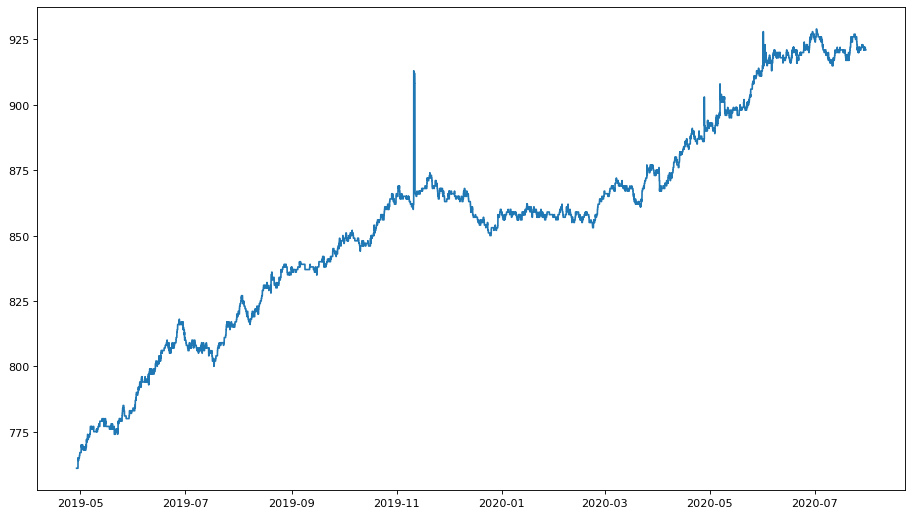

In [4]:
all_data = coll_status.find({})

counts = []
dates = []

i = 0
for s in all_data:
    i += 1
    if i % 2 > 0:
        continue
    offline = s.get('offline')
    if offline == 0:
        continue
    count = s.get('online') + s.get('dnd') + s.get('away') + offline
    counts.append(count)
    dates.append(s.get('timestamp'))
    
plt.figure(figsize=(14, 8), dpi=80)
plt.plot(dates, counts)
plt.show()

## Status Counts over Time

First of all, we prepare a method to fetch data and generate a plot of all online states of the specified count of last days.

In [5]:
def status_plot_last_x_days(days):
    status_data = coll_status.find({
        'timestamp': {
            '$gte': datetime.today() - timedelta(days=days)
        }
    })
    
    online = []
    offline = []
    dnd = []
    away = []
    dates = []
    
    i = 0
    for s in status_data.clone():
        i += 1
        # Only take every 2nd value
        if i % 2 == 0:
            continue
        
        # Some of the offline values are errous and
        # value to 0, so this filters these values
        # out for a cleaner result.
        offl = s.get('offline')
        if offl == 0:
            offl = offline[-1]
        offline.append(offl)
        
        online.append(s.get('online'))
        dnd.append(s.get('dnd'))
        away.append(s.get('away'))
        dates.append(s.get('timestamp'))
        
        
    fig = plt.figure(figsize=(14, 8), dpi=80)
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.plot(dates, online, 'g')
    a1.plot(dates, dnd, 'r')
    a1.plot(dates, away, 'y')
#   a2 = a1.twinx()
#   a2.plot(dates, offline, 'b')
    fig.legend(('online', 'dnd', 'away'), loc='upper left')
    plt.show()

So, this is the evolution of player counts for each online status (`online`, `dnd`, `away`) over the last 30 days.

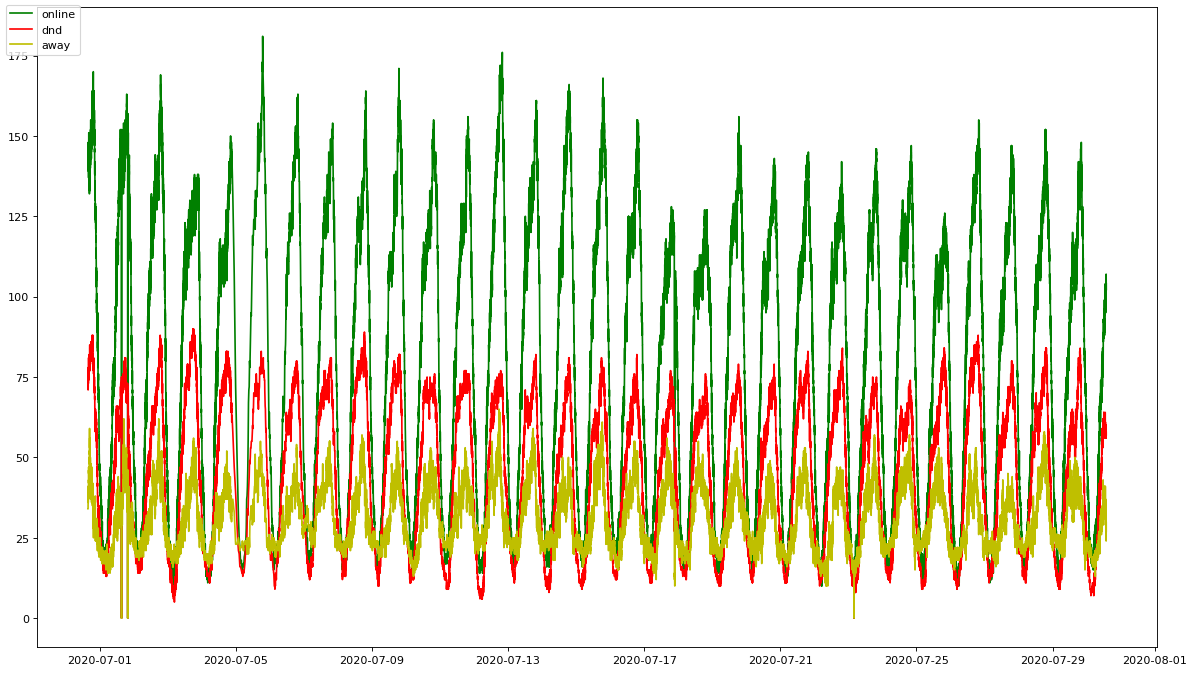

In [6]:
status_plot_last_x_days(30)

And this is a more detailed view over the last 7 days.

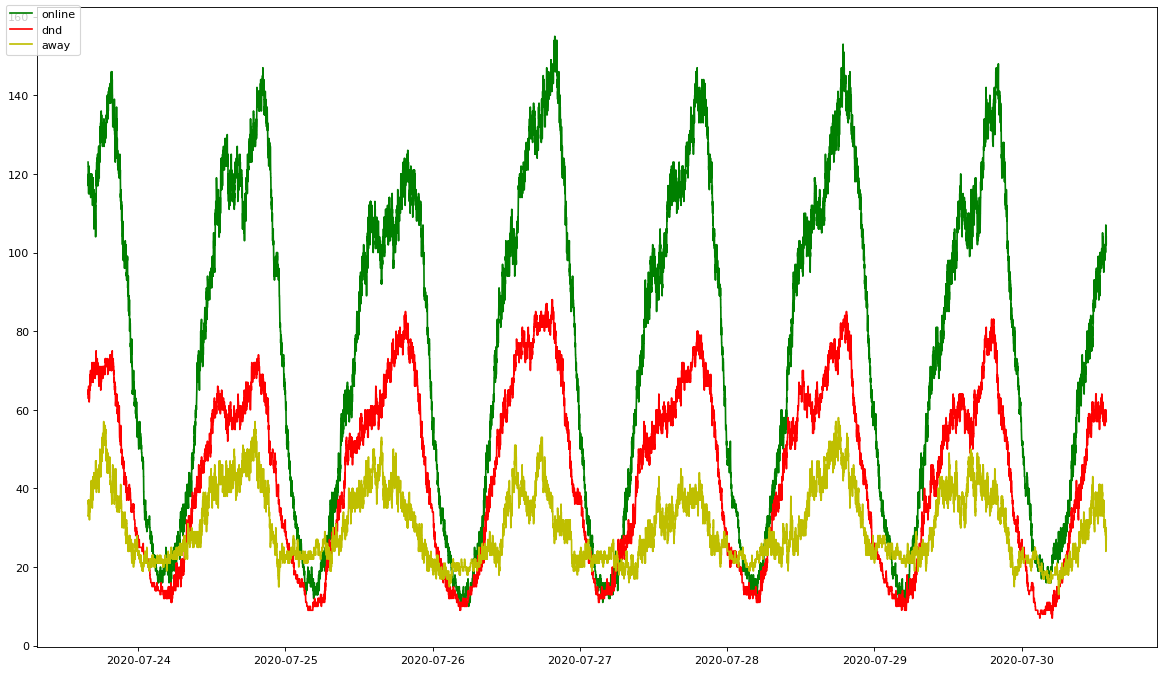

In [7]:
status_plot_last_x_days(7)

## Average Count of Online Users over Time

In the following chart you see the evolution of online users for each status averaged over the time span of a day over time.

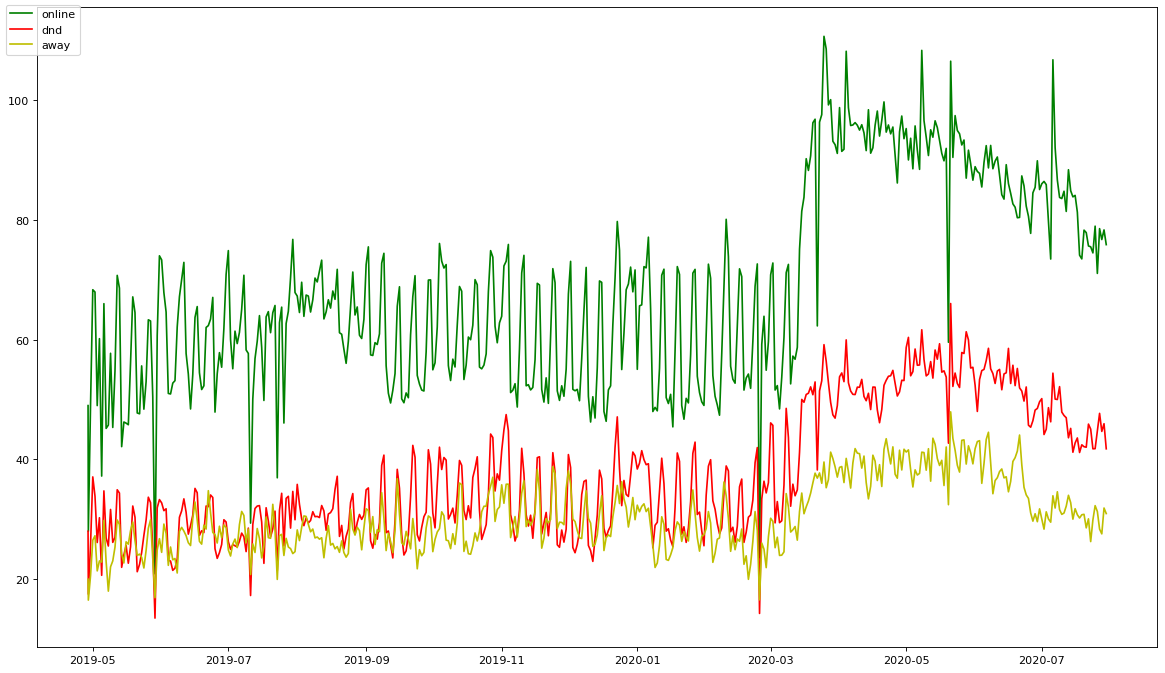

In [8]:
status_data = coll_status.find({})

online = []
offline = []
dnd = []
away = []
dates = []

c_online = 0
c_offline = 0
c_dnd = 0
c_away = 0

last_day = 1
i = 0
for s in status_data.clone():
    date = s.get('timestamp')
    c_online += s.get('online')
    c_offline += s.get('offline')
    c_dnd += s.get('dnd')
    c_away += s.get('away')
    i += 1
    if last_day != date.day:
        last_day = date.day
        online.append(c_online / i)
        offline.append(c_offline / i)
        dnd.append(c_dnd / i)
        away.append(c_away / i)
        dates.append(date)
        c_online = 0
        c_offline = 0
        c_dnd = 0
        c_away = 0
        i = 0
        
fig = plt.figure(figsize=(14, 8), dpi=80)
a1 = fig.add_axes([0, 0, 1, 1])
a1.plot(dates, online, 'g')
a1.plot(dates, dnd, 'r')
a1.plot(dates, away, 'y')
# a2 = a1.twinx()
# a2.plot(dates, offline, 'b')
fig.legend(('online', 'dnd', 'away'), loc='upper left')
plt.show()

## Average Online Counts over the Day

For this purpose, we create a function which averages the ammount of users having the status `online`, `dnd` and `away`. The passed `time_func` is getting passed a `datetime` object and returns a float number which is used as key for the average map.

In [9]:
def average_status_over_time(time_func):
    averages_on_times = {}

    for s in status_data.clone():
        ts = s.get('timestamp')
        c_online = s.get('online')
        c_dnd = s.get('dnd')
        c_away = s.get('away')

        t = time_func(ts)
        if t not in averages_on_times:
            averages_on_times[t] = {
                'online': c_online,
                'dnd': c_dnd,
                'away': c_away,
                'n': 1
            }
        else:
            averages_on_times[t]['online'] += c_online
            averages_on_times[t]['dnd'] += c_dnd
            averages_on_times[t]['away'] += c_away
            averages_on_times[t]['n'] += 1

    times = []
    online = []
    dnd = []
    away = []

    items = sorted(averages_on_times.items(), key=lambda x: x[0])

    for t, v in items:
        times.append(t)
        n = v.get('n')
        online.append(v.get('online') / n)
        dnd.append(v.get('dnd') / n)
        away.append(v.get('away') / n)

    fig = plt.figure(figsize=(14, 8), dpi=80)
    plt.plot(times, online, 'g')
    plt.plot(times, dnd, 'r')
    plt.plot(times, away, 'y')
    fig.legend(('online', 'dnd', 'away'), loc='upper left')
    plt.show()

First, we average the ammount of users over 24 hours. So, our key expression looks like following:

$$
f(h, m) = \frac{60 h + m}{60}
$$

As you can see, it seems like there is kind os a noise in the data. Actually, I have no idea why the plot is so jittery, maybe my calculation method is wrong? To be honest, I have no idea. :D

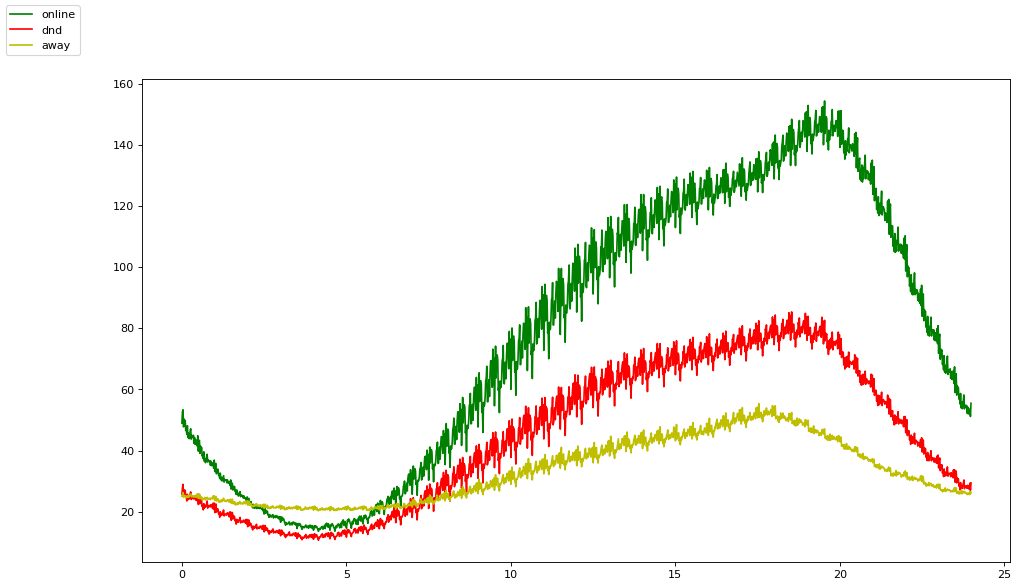

In [10]:
average_status_over_time(lambda ts: (ts.hour * 60 + ts.minute) / 60)

Following, we build the average over a whole week using the following function:

$$
f(wd, h) = wd + \frac{h}{24}
$$

As you can see, this just gives us a less-detailed version of the graph above with each specific average for each week-day. This shows that the average activity is relatively equal each day over a week.

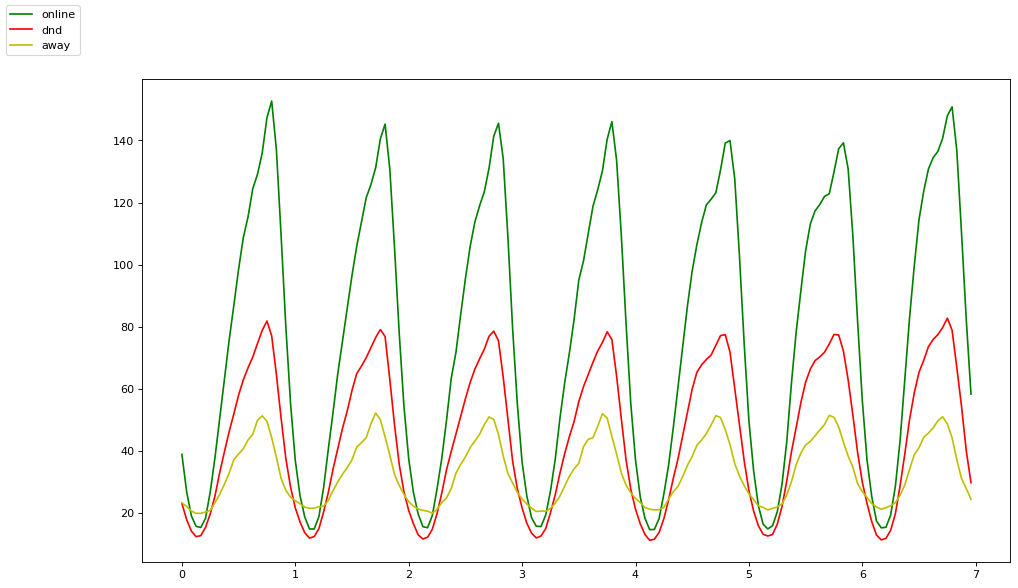

In [11]:
average_status_over_time(lambda ts: ts.weekday() + (ts.hour / 24))

To make the data a little bit "cleaner", we just lower the averaging resolution to single week days. So, the key function is simply

$$
f(wd) = wd
$$

And this shows now more clearly that the average activity is relatively evenly distributed with a little growth against the weekend (`0` is `Monday`) and a low in the middle of the week around wednesday and thursday.

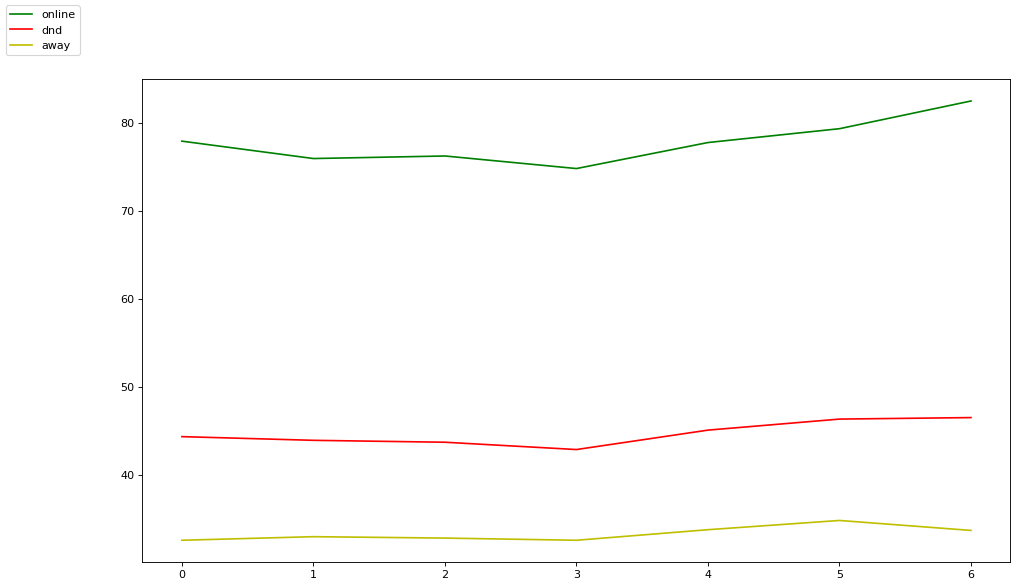

In [12]:
average_status_over_time(lambda ts: ts.weekday())

Just for fun, we do the same over a whole month by using each day of the month as key value, which simply gives the following key function:

$$
f(d) = d
$$

Keep in mind that not all months have the equal ammount of days of `31` on maximum. So, the ammount of values is way less dense between the 28th and 31th day of the months.

Also this graph tells that the ammount of active users is verry evenly distributed over the month with a little peak at the first and the 28th day, for whatever reason.

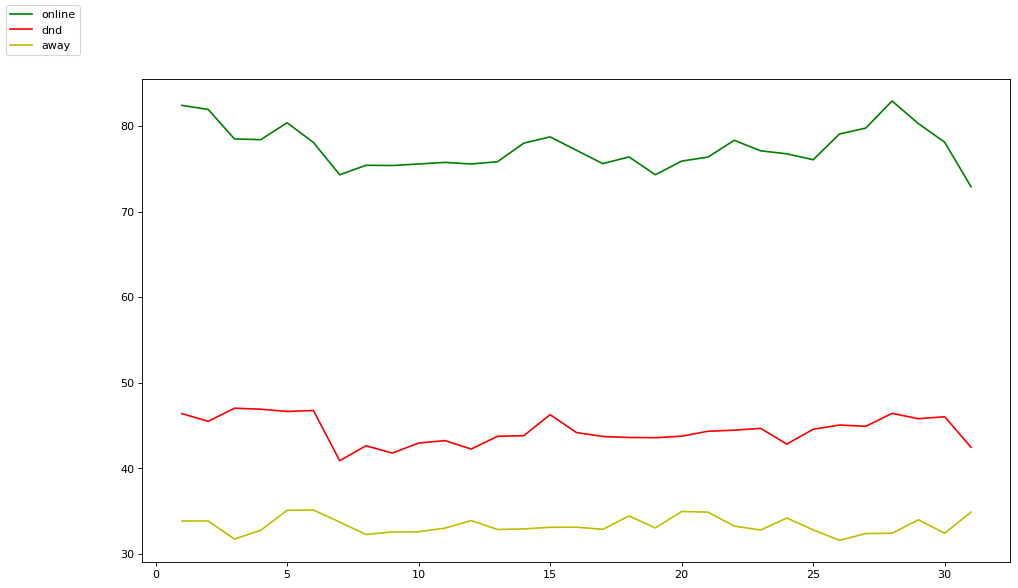

In [13]:
average_status_over_time(lambda ts: ts.day)

## Status Statistics per Role

For this analysis, we are using another data collection named `statusroles` which also recorded the ammount of members online for each online status, but this time split up to each role on the guild.

The idea was to analyze if the patterns differ by role. So I thought it would be possible to see if a specific roles is more active at other times than other roles, for example.

But as you can see, because the ammount of users in these roles in not quiet high - only around 10 or so users per role - the graph is distorted and does not really show much information, sadly.

Maybe, it would be possible to smooth out the data a bit to give more overview, but I have no idea how to do that to be honest. :D

In [14]:
coll_status_roles = mongo_db['statusroles']

In [15]:
def status_roles_plot_last_x_days(days):
    # Object with following structure:
    # { 'role_name': { 'date': count } }
    role_stats = {
        'Admin': {},
        'Moderator': {},
        'Supporter': {},
        'Bot': {},
    }

    status_roles_data = coll_status_roles.find({
        'timestamp': {
            '$gte': datetime.today() - timedelta(days=days)
        }
    })

    i = 0
    for s in status_roles_data.clone():
        i += 1
        if i % 2 > 0:
            continue
        ts = s.get('timestamp')
        for r in s.get('roles'):
            r_name = get_role_name(r.get('roleid'))
            count = r.get('online') + r.get('dnd') + r.get('away')
            if r_name not in role_stats:
                continue
            role_stats[r_name][ts] = count


    fig = plt.figure(figsize=(14, 8), dpi=80)

    legends = []
    for r_name, v in role_stats.items():
        plt.plot(list(v.keys()), list(v.values()))
        legends.append(r_name)

    fig.legend(legends, loc='upper left')
    plt.show()

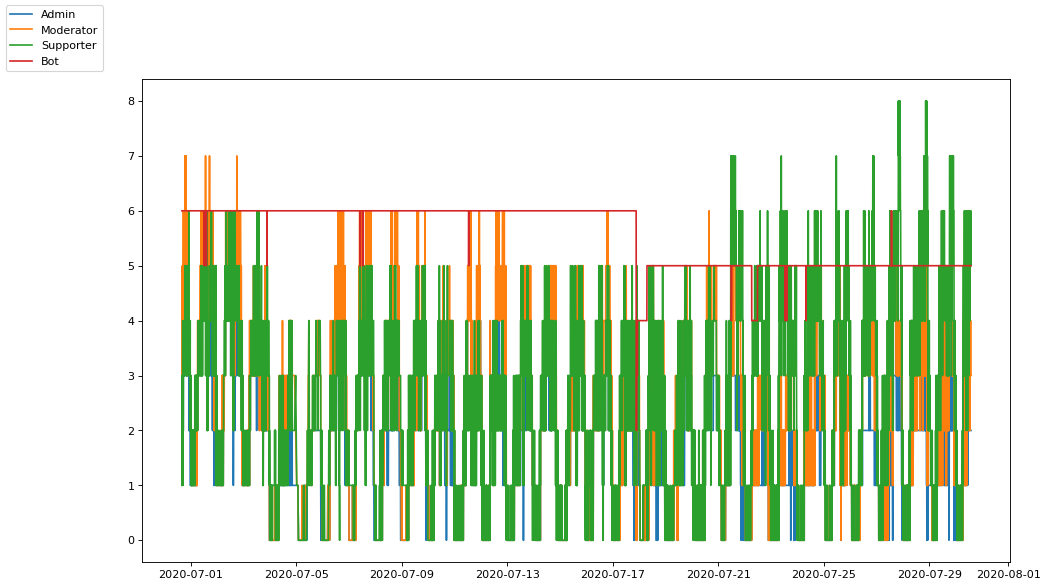

In [16]:
status_roles_plot_last_x_days(30)

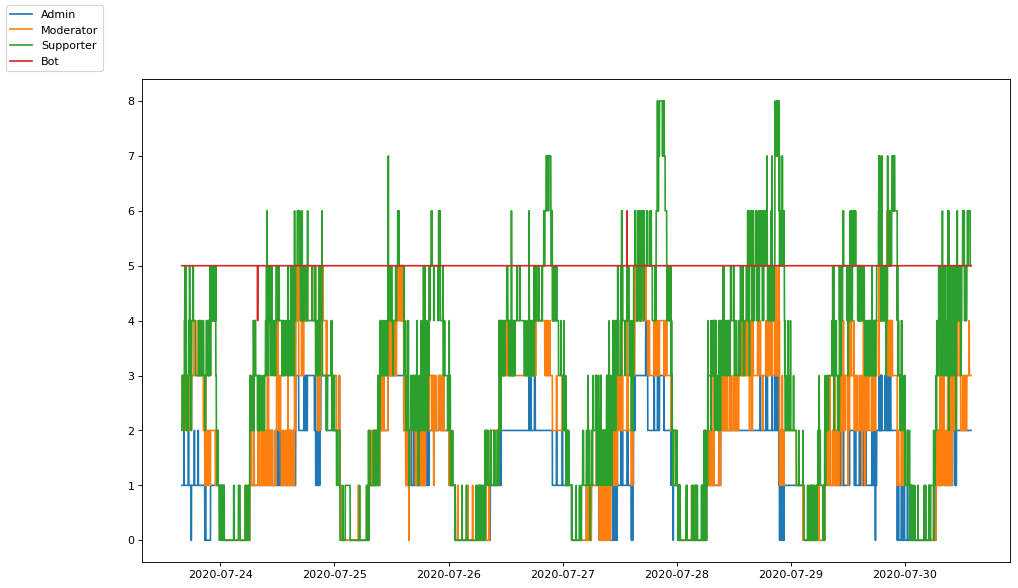

In [17]:
status_roles_plot_last_x_days(7)